# Homework 6

In this homework you will be training and using a "char-RNN". This is the name given to a character-level recurrent neural network language model by [this famous blog post by Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). Before you start on the rest of the homework, please give the blog post a read, it's quite good!

I don't expect you to implement the char-RNN from scratch. Andrej's original char-rnn is in Torch (the predecessor to PyTorch that is not commonly used anymore). Fortunately, there are many other implementations of this model available; for example, there is one (in both mxnet and pytorch) in chapters 8 and 9 of [the textbook](http://d2l.ai), and another pytorch one [here](https://github.com/spro/char-rnn.pytorch). **Please use one of these example implementations (or another one that you find) when completing this homework**.

For this homework, please complete the following steps:

1. Download and tokenize the [Shakespeare dataset](http://www.gutenberg.org/files/100/100-0.txt) at a character level. I recommend basing your solution on the following code:
```Python
# Remove non-alphabetical characters, lowercase, and replace whitespace with ' '
raw_dataset = ' '.join(re.sub('[^A-Za-z ]+', '', text).lower().split())
# Maps token index to character
idx_to_char = list(set(raw_dataset))
# Maps character to token index
char_to_idx = dict([(char, i) for i, char in enumerate(idx_to_char)])
# Tokenize the dataset
corpus_indices = [char_to_idx[char] for char in raw_dataset]
```
1. Train a "vanilla" RNN (as described in chapter 9 of [the textbook](http://d2l.ai)) on the Shakespeare dataset. Report the training loss and generate some samples from the model at the end of training.
1. Train a GRU RNN (as described in chapter 10 of [the textbook](http://d2l.ai)) on the Shakespeare datatset. Is the final training loss higher or lower than the vanilla RNN? Are the samples from the model more or less realistic?
1. Find a smaller, simpler dataset than the Shakespeare data (you can find some ideas in Andrej's blog post, but feel free to get creative!) and train either the vanilla or GRU RNN on it instead. Is the final training loss higher or lower than it was for the Shakespeare data?

**Datasets**

Shakespeare Dataset: [https://drive.google.com/file/d/1PH5-oJcX_APwYg9FqusVU8nfZ4Mv5Llo/view?usp=share_link](https://drive.google.com/file/d/1PH5-oJcX_APwYg9FqusVU8nfZ4Mv5Llo/view?usp=share_link)

ROCStories: [https://drive.google.com/file/d/125kwIrPVMZ2_TvgEJhHYfiun3flllErS/view?usp=sharing](https://drive.google.com/file/d/125kwIrPVMZ2_TvgEJhHYfiun3flllErS/view?usp=sharing)

## Problem 1: Text Preprocessing

In [ ]:
import re
import collections
import random
import re
import torch
%matplotlib inline
import math
from torch import nn
from torch.nn import functional as F
!pip install d2l==1.0.0-beta0
from d2l import torch as d2l
device = "cuda:0" if torch.cuda.is_available() else "cpu"

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
rocs_path = '/content/drive/MyDrive/Data/Text/winter_2017.txt'
shakes_path = '/content/drive/MyDrive/Data/Text/shakespeare.txt'

rocs_list = open(rocs_path, "r").readlines()
shakes_list = open(shakes_path, "r").readlines()
print('rocs len: {}\nshakes len: {}\n'.format(len(rocs_list), len(shakes_list)))

rocs = ''.join(rocs_list)
shakes = ''.join(shakes_list)

print('rocs vocab: {}'.format(set(rocs)))
print('rocs vocab length: {}\n'.format(len(set(rocs))))
print('shakes vocab: {}'.format(set(shakes)))
print('shakes vocab length: {}'.format(len(set(shakes))))

rocs len: 52665
shakes len: 178446

rocs vocab: {'0', '&', ' ', 'N', '$', '2', 'r', 'g', 'm', 'W', 'j', ',', '.', ':', 'P', 'H', 'p', 's', 'o', 'q', '*', 'M', '%', 'E', 'Z', 'k', ')', 'f', '[', 'z', 'I', 'i', 'x', 'e', 'y', '3', '/', '7', 'u', 'L', 'v', "'", 'a', '8', 'J', '?', 't', 'X', ';', '`', '1', 'R', 'O', '6', 'n', 'Q', '-', '>', 'Y', 'C', '"', '5', 'A', 'K', '(', '!', 'w', '\n', 'c', 'S', '\\', 'F', 'D', 'T', '4', 'b', 'U', '9', 'G', 'l', 'h', 'd', '#', 'B', '+', 'V'}
rocs vocab length: 86

shakes vocab: {'0', '&', ' ', 'N', '$', '2', 'r', 'g', 'm', 'W', 'j', ',', '.', ':', 'P', 's', 'p', 'H', 'Æ', 'ë', 'o', '—', 'é', 'q', '*', 'M', '%', 'E', '}', 'Z', 'æ', '\ufeff', 'k', ')', 'f', '[', 'z', 'I', 'É', 'i', 'è', '‘', 'x', 'ê', 'e', 'Ç', 'y', '3', '/', '7', 'u', 'L', 'v', '|', '’', 'à', "'", 'a', '8', 'œ', 'J', '™', '?', 't', 'X', ';', '“', 'î', '1', 'R', 'O', '6', 'n', 'Q', '-', '…', 'Y', 'C', '"', '5', 'A', ']', '”', 'K', '(', '!', 'w', '_', 'ç', '\n', 'c', 'S', '•', 'â', '\\',

In [ ]:
shakes_vocab = list(map(lambda x : ord(x), list(set(shakes))))
rocs_vocab = list(map(lambda x : ord(x), list(set(rocs))))

In [ ]:
def preprocess(text):
  # Remove non-alphabetical characters, lowercase, and replace whitespace with ' '
  raw_dataset = ' '.join(re.sub('[^A-Za-z ]+', '', text).lower().split())
  # Maps token index to character
  idx_to_char = list(set(raw_dataset))
  # Maps character to token index
  char_to_idx = dict([(char, i) for i, char in enumerate(idx_to_char)])
  # Tokenize the dataset
  corpus_indices = [char_to_idx[char] for char in raw_dataset]

  return corpus_indices

In [ ]:
rocs_processed = preprocess(rocs)
shakes_processed = preprocess(shakes)
print(type(shakes_processed))
print('rocs len: {}\nshakes len: {}'.format(len(rocs_processed), len(shakes_processed)))

<class 'list'>
rocs len: 11395276
shakes len: 4908247


### Define dataloader

In [ ]:
max_epochs = 50

In [ ]:
class TextDataLiesl(d2l.DataModule):
    def __init__(self, batch_size, num_steps, raw_text, num_train=10000, num_val=5000):
      """Defined in :numref:`sec_language-model`"""
      #super(d2l.TextDataLiesl, self).__init__()
      super().__init__()
      self.save_hyperparameters()
      corpus, self.vocab = self.build(raw_text)
      array = d2l.tensor([corpus[i:i+num_steps+1]
                          for i in range(len(corpus)-num_steps)])
      self.X, self.Y = array[:,:-1], array[:,1:]

    def get_dataloader(self, train):
      """Defined in :numref:`subsec_partitioning-seqs`"""
      idx = slice(0, self.num_train) if train else slice(
          self.num_train, self.num_train + self.num_val)
      return self.get_tensorloader([self.X, self.Y], train, idx)

    def _preprocess(self, text):
      return re.sub('[^A-Za-z]+', ' ', text).lower()

    def _tokenize(self, text):
      return list(text)

    def build(self, raw_text, vocab=None):
      tokens = self._tokenize(self._preprocess(raw_text))
      if vocab is None: vocab = Vocab(tokens)
      corpus = [vocab[token] for token in tokens]
      return corpus, vocab

In [ ]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

## Problem 2: Vanilla RNN

In [ ]:
class RNNScratch(d2l.Module):
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

    def forward(self, inputs, state=None):
      if state is None:
          # Initial state with shape: (batch_size, num_hiddens)
          state = torch.zeros((inputs.shape[1], self.num_hiddens),
                            device=inputs.device)
      else:
          state, = state
      outputs = []
      for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
          state = torch.tanh(torch.matmul(X, self.W_xh) +
                          torch.matmul(state, self.W_hh) + self.b_h)
          outputs.append(state)
      return outputs, state

In [ ]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens).to(device)
X = torch.ones((num_steps, batch_size, num_inputs)).to(device)
outputs, state = rnn(X)

In [ ]:
def check_len(a, n):
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'

def check_shape(a, shape):
    """Check the shape of a tensor."""
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'

check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))

In [ ]:
class RNNLMScratch(d2l.Classifier):
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()
        self.train_loss = []
        self.valid_loss = []

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        self.train_loss.append(l)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)
        self.valid_loss.append(l)

    def one_hot(self, X):
        # Output shape: (num_steps, batch_size, vocab_size)
        return F.one_hot(X.T, self.vocab_size).type(torch.float32)

    def output_layer(self, rnn_outputs):
        outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
        return torch.stack(outputs, 1)

    def forward(self, X, state=None):
        embs = self.one_hot(X)
        rnn_outputs, _ = self.rnn(embs, state)
        return self.output_layer(rnn_outputs)

    def clip_gradients(self, grad_clip_val, model):
        params = [p for p in model.parameters() if p.requires_grad]
        norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
        if norm > grad_clip_val:
            for param in params:
                param.grad[:] *= grad_clip_val / norm

    def predict(self, prefix, num_preds, vocab, device=None):
        state, outputs = None, [vocab[prefix[0]]]
        for i in range(len(prefix) + num_preds - 1):
            X = torch.tensor([[outputs[-1]]], device=device)
            embs = self.one_hot(X)
            rnn_outputs, state = self.rnn(embs, state)
            if i < len(prefix) - 1:  # Warm-up period
                outputs.append(vocab[prefix[i + 1]])
            else:  # Predict num_preds steps
                Y = self.output_layer(rnn_outputs)
                outputs.append(int(Y.argmax(axis=2).reshape(1)))
        return ''.join([vocab.idx_to_token[i] for i in outputs])

In [ ]:
# Check class implementation
model = RNNLMScratch(rnn, num_inputs).to(device)
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64).to(device))
check_shape(outputs, (batch_size, num_steps, num_inputs))

In [ ]:
inputs = ['the mind in', 'he saw a fox ', 'thou art ', 'to be or not ', 'she stood on ', 'before the start ', 'thou speakest']

Train loss = 1.61457, Validation loss = 1.99995 after 50 epochs


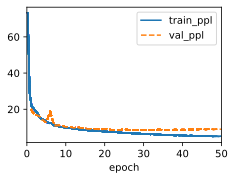

In [ ]:
shakes_data = TextDataLiesl(batch_size=512, num_steps=32, raw_text=shakes)
rnn = RNNScratch(num_inputs=len(shakes_vocab), num_hiddens=64).to(device)
model = RNNLMScratch(rnn, vocab_size=len(shakes_vocab), lr=1.5).to(device)
trainer = d2l.Trainer(max_epochs=max_epochs, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, shakes_data)
print("Train loss = {0:2.5f}, Validation loss = {1:2.5f} after {2} epochs".format(model.train_loss[-1], model.valid_loss[-1], max_epochs))

In [ ]:
for i in range(len(inputs)):
  print(model.predict(inputs[i], 30, shakes_data.vocab, d2l.try_gpu()))

the mind in his welling the tount the tou
he saw a fox thou and the tount the tount t
thou art thou so ford surs of thou seas
to be or not werteld the touth s love to th
she stood on the william shakespeare the to
before the start of her gease when yourself sul
thou speakest and ond your st thou and the 


## Problem 3

In [ ]:
class GRUScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xz, self.W_hz, self.b_z = triple()  # Update gate
        self.W_xr, self.W_hr, self.b_r = triple()  # Reset gate
        self.W_xh, self.W_hh, self.b_h = triple()  # Candidate hidden state

    def forward(self, inputs, H=None):
        if H is None:
            # Initial state with shape: (batch_size, num_hiddens)
            H = torch.zeros((inputs.shape[1], self.num_hiddens),
                          device=inputs.device)
        outputs = []
        for X in inputs:
            Z = torch.sigmoid(torch.matmul(X, self.W_xz) +
                            torch.matmul(H, self.W_hz) + self.b_z)
            R = torch.sigmoid(torch.matmul(X, self.W_xr) +
                            torch.matmul(H, self.W_hr) + self.b_r)
            H_tilde = torch.tanh(torch.matmul(X, self.W_xh) +
                              torch.matmul(R * H, self.W_hh) + self.b_h)
            H = Z * H + (1 - Z) * H_tilde
            outputs.append(H)
        return outputs, H

Train loss = 1.46840, Validation loss = 1.83130 after 35 epochs


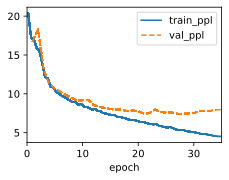

In [ ]:
max_epochs=35
shakes_data = TextDataLiesl(batch_size=512, num_steps=32, raw_text=shakes)
gru = GRUScratch(num_inputs=len(shakes_data.vocab), num_hiddens=64).to(device)
model = RNNLMScratch(gru, vocab_size=len(shakes_data.vocab), lr=4).to(device)
trainer = d2l.Trainer(max_epochs=max_epochs, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, shakes_data)
print("Train loss = {0:2.5f}, Validation loss = {1:2.5f} after {2} epochs".format(model.train_loss[-1], model.valid_loss[-1], max_epochs))

In [ ]:
for i in range(len(inputs)):
  print(model.predict(inputs[i], 30, shakes_data.vocab, d2l.try_gpu()))

the mind in the will and self sou summ sh
he saw a fox his beauty s love in the will 
thou art sweet self son sull st thou sh
to be or not live and self son sull st thou
she stood on on on on on on on on on on on 
before the start of will and she beauty s love 
thou speakest and self son sull st thou sho


The final training loss (both training and validation loss) is lower than the vanilla RNN.The samples from the GRU model is also more realistic. It learns new words such as "will", "self", "beauty", etc. There are some repetitive words but overall does better than the vanilla RNN.

## Problem 4

**Losses**

Vanilla RNN:

> Shakespeare : Train loss = 1.61457, Validation loss = 1.99995

> ROCStories : Train loss = 1.72123, Validation loss = 2.01086

> Time Machine : Train loss = 1.94205, Validation loss = 2.07208

GRU RNN:

> Shakespeare : Train loss = 1.46840, Validation loss = 1.83130

> ROCStories : Train loss = 1.67392, Validation loss = 1.95233

> Time Machine : Train loss = 1.48543, Validation loss = 2.00373

Train loss = 1.72123, Validation loss = 2.01086 after 50 epochs


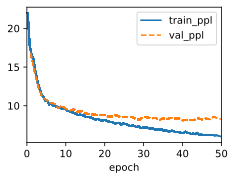

In [ ]:
rocs_data = TextDataLiesl(batch_size=512, num_steps=8, raw_text=rocs)
rnn = RNNScratch(num_inputs=len(rocs_data.vocab), num_hiddens=64).to(device)
model = RNNLMScratch(rnn, vocab_size=len(rocs_data.vocab), lr=2).to(device)
trainer = d2l.Trainer(max_epochs=max_epochs, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, rocs_data)
print("Train loss = {0:2.5f}, Validation loss = {1:2.5f} after {2} epochs".format(model.train_loss[-1], model.valid_loss[-1], max_epochs))

In [ ]:
for i in range(len(inputs)):
  print(model.predict(inputs[i], 30, rocs_data.vocab, d2l.try_gpu()))

the mind in to the to the to the to the t
he saw a fox he decided to the to the to th
thou art so the college the could to th
to be or not to the the college the could t
she stood on the college the could to the t
before the start she was he she he was he the c
thou speakest he the could to the the colle


Train loss = 1.67392, Validation loss = 1.95233 after 50 epochs


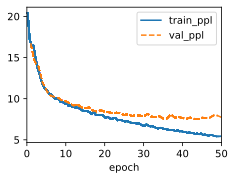

In [ ]:
rocs_data = TextDataLiesl(batch_size=512, num_steps=8, raw_text=rocs)
gru = GRUScratch(num_inputs=len(rocs_data.vocab), num_hiddens=64).to(device)
model = RNNLMScratch(gru, vocab_size=len(rocs_data.vocab), lr=4).to(device)
trainer = d2l.Trainer(max_epochs=max_epochs, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, rocs_data)
print("Train loss = {0:2.5f}, Validation loss = {1:2.5f} after {2} epochs".format(model.train_loss[-1], model.valid_loss[-1], max_epochs))

In [ ]:
for i in range(len(inputs)):
  print(model.predict(inputs[i], 30, rocs_data.vocab, d2l.try_gpu()))

the mind in the the pas she had a stor a 
he saw a fox he stanted to the the pas she 
thou art she had a stor a neck in the t
to be or not in the the pas she had a stor 
she stood on the pais on the propped to the
before the start to the the pas she had a stor 
thou speakested to the the pas she had a st


Train loss = 1.94205, Validation loss = 2.07208 after 50 epochs


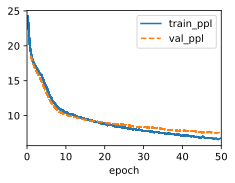

In [ ]:
data = d2l.TimeMachine(batch_size=512, num_steps=8)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=64).to(device)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1).to(device)
trainer = d2l.Trainer(max_epochs=max_epochs, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)
print("Train loss = {0:2.5f}, Validation loss = {1:2.5f} after {2} epochs".format(model.train_loss[-1], model.valid_loss[-1], max_epochs))

In [ ]:
for i in range(len(inputs)):
  print(model.predict(inputs[i], 30, data.vocab, d2l.try_gpu()))

the mind in a four a dimensions of the th
he saw a fox the time the time the time the
thou art and his a mentions of the the 
to be or not a four a dimensions of the the
she stood on a four a dimensions of the the
before the start and his a mentions of the the 
thou speakest and his a mentions of the the


Train loss = 1.48543, Validation loss = 2.00373 after 50 epochs


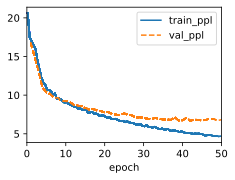

In [ ]:
data = d2l.TimeMachine(batch_size=512, num_steps=8)
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=64).to(device)
model = RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4).to(device)
trainer = d2l.Trainer(max_epochs=max_epochs, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)
print("Train loss = {0:2.5f}, Validation loss = {1:2.5f} after {2} epochs".format(model.train_loss[-1], model.valid_loss[-1], max_epochs))

In [ ]:
for i in range(len(inputs)):
  print(model.predict(inputs[i], 30, data.vocab, d2l.try_gpu()))

the mind in time travel the time travel t
he saw a fox the time travel the time trave
thou art me time travel the time travel
to be or not time travel the time travel th
she stood on time travel the time travel th
before the start the time travel the time trave
thou speakest thing time travel the time tr


We can note the comparision of losses between all the models (in the start of Problem 4 summarized above). We can see that in general GRU models perform better in loss value then the vanilla model but they suffer from the problem of repetitive words. In GRU models, the losses of Time Machine data is comparable to the Shakespeare dataset (both losses are low) but in vanilla models, Shakespeare data achieves the lowest loss value out of the other 2 datasets. Qualitatively, we can see that the words generated in both models have many repetitions.